<a href="https://colab.research.google.com/github/reshalfahsi/neuralnetwork/blob/main/notebook/NeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Install Package**

In [1]:
!git clone https://github.com/reshalfahsi/neuralnetwork
%cd neuralnetwork
!pip install -q .

Cloning into 'neuralnetwork'...
remote: Enumerating objects: 319, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 319 (delta 99), reused 119 (delta 60), pack-reused 161
Receiving objects: 100% (319/319), 36.34 MiB | 19.46 MiB/s, done.
Resolving deltas: 100% (147/147), done.
/content/neuralnetwork
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 87 kB 4.9 MB/s 


## **Hyperparameters**

In [2]:
NUM_EPOCHS = 32
BATCH_SIZE = 16
lr = 1e-2

## **Dataset Preparation**

This tutorial will use a toy dataset from [MedMNIST](https://medmnist.com/). We use PneumoniaMNIST, which contains 2D X-ray image-label pairs for distinguishing between Pneumonia-infected and healthy lungs. The pneumonia-infected lung is denoted by the label `1` whilst the healthy lung is labeled as `0`.

In [3]:
from neuralnetwork.ds.medmnist import PneumoniaMNIST
from neuralnetwork import ds
import numpy as np


train_dataset = PneumoniaMNIST(split='train', download=True)
test_dataset = PneumoniaMNIST(split='test', download=True)

print("Train Dataset:", len(train_dataset))
print("Test Dataset", len(test_dataset))

  0%|          | 0/4170669 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Train Dataset: 4708
Test Dataset 624


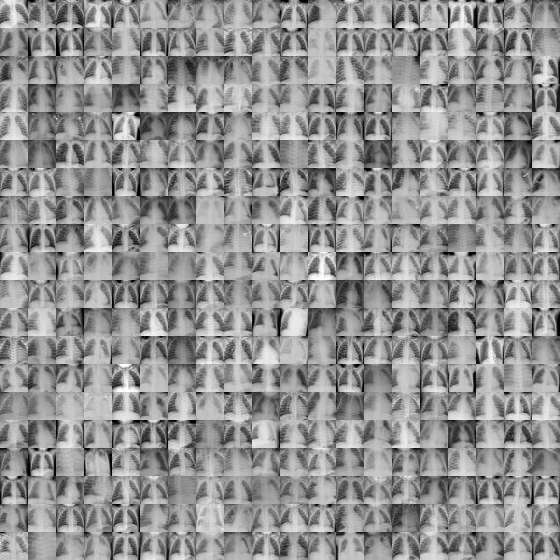

In [4]:
train_dataset.montage(length=20)

## **Neural Network**

The artificial neural network is a bio-inspired machine learning method that models neuronal signal propagation by matrix multiplication. Here we have two kinds of neuronal signal propagation: forward propagation and backward propagation. In forward propagation, the neuron actively conveys information from the "receptor" (or input) to the "central nervous system" (or output). Backward propagation or backpropagation, in short, is utilized in the training or learning process. In the learning process, the neural network transmits error gradients from the "central nervous system" to the "receptor". For further knowledge about the learning process, read more: [Calculus on Computational Graphs: Backpropagation](https://colah.github.io/posts/2015-08-Backprop/) and [Backpropagation for a Linear Layer
](https://web.eecs.umich.edu/~justincj/teaching/eecs442/notes/linear-backprop.html).

In [5]:
import neuralnetwork.nn as nn


class NeuralNetwork(nn.Module):
    def __init__(self, **kwargs):
        super(NeuralNetwork, self).__init__(**kwargs)
        self.linear0 = nn.Linear(784, 200, **kwargs)
        self.linear1 = nn.Linear(200, 200, **kwargs)
        self.linear2 = nn.Linear(200, 1, **kwargs)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        self.out0 = self.linear0(x)
        self.out1 = self.sigmoid(self.out0)
        self.out2 = self.linear1(self.out1)
        self.out3 = self.sigmoid(self.out2)
        self.out4 = self.linear2(self.out3)
        self.out5 = self.sigmoid(self.out4)

        return self.out5
    
    def backward(self, lr, criterion, method=None):
                                                               # Computational Graph
                                                               #
        self.dx0 = criterion.grad()                            # loss_grad(pred, y)
                                                               #        |
        self.dx1 = self.sigmoid.grad(self.out4)                # sigmoid_grad(pred)
                                                               #        |
                                                               #        +
                                                               #       / \
                                                               #      |   |
                                                               #  b_grad  *
                                                               #         / \
                                                               #        |   |
        self.dx2 = self.linear2.grad(self.dx1 * self.dx0)      #   A_grad   x_grad
                                                               #          .
        self.dx3 = self.sigmoid.grad(self.out2)                #          .
        self.dx4 = self.linear1.grad(self.dx3 * self.dx2)      #          .

        self.dx5 = self.sigmoid.grad(self.out0)
        self.dx6 = self.linear0.grad(self.dx5 * self.dx4)

        #-----------------------------------------------------

        if method == 'newton':
            self.d2x0 = criterion.grad('hessian')                                                        
            self.d2x1 = self.sigmoid.grad(self.out4, 'hessian')

            gradient = {
                'error_first': self.dx0,
                'error_second': self.d2x0,
                'nonlinearity_first': self.dx1,
                'nonlinearity_second': self.d2x1,
            }               

            self.d2x2 = self.linear2.grad(gradient, 'hessian')
            self.d2x3 = self.sigmoid.grad(self.out2, 'hessian') 

            gradient = {
                'error_first': self.dx2,
                'error_second': self.d2x2,
                'nonlinearity_first': self.dx3,
                'nonlinearity_second': self.d2x3,
            }         
                                                                            
            self.d2x4 = self.linear1.grad(gradient, 'hessian')
            self.d2x5 = self.sigmoid.grad(self.out0, 'hessian')

            gradient = {
                'error_first': self.dx4,
                'error_second': self.d2x4,
                'nonlinearity_first': self.dx5,
                'nonlinearity_second': self.d2x5,
            } 

            self.d2x6 = self.linear0.grad(gradient, 'hessian')

        #-----------------------------------------------------

        self.linear0.update(lr, method)
        self.linear1.update(lr, method)
        self.linear2.update(lr, method)

## **Training**

In [6]:
import time	


def accuracy(model, X, Y):
    pred = model(X)
    pred = pred > 0.5
    acc = np.sum(pred == Y)
    acc = acc / Y.shape[0]
    return acc

seed = np.random.randint(2147483647)
print(seed)

633030033


### **Gradient Descent**

In [10]:
train_loader = ds.get_loader(dataset=train_dataset, batch_size=BATCH_SIZE)
test_loader = ds.get_loader(dataset=test_dataset, batch_size=1)

criterion = nn.MSELoss()
np.random.seed(seed)
model = NeuralNetwork()


start = time.perf_counter()
for epoch in range(NUM_EPOCHS):
    loss = list()
    acc = list()
    for idx, pack in enumerate(train_loader):
        x, y = pack
        bs = x.shape[0]
        L = x.shape[1] * x.shape[2]
        x = x.reshape(bs, 1, L) / 255.0
        y = y.reshape(bs, 1, 1)
        pred = model(x)
        loss.append(criterion(pred, y))
        model.backward(lr, criterion)
        acc.append(accuracy(model, x, y))
        if idx % 20 == 0 or idx == len(train_dataset) - 1:
            print(
                "{}/{} - The training loss at {}th epoch : {}  Training Accuracy:{}".format(
                    idx + 1,
                    len(train_dataset) // BATCH_SIZE,
                    epoch + 1,
                    np.array(loss).mean(),
                    np.array(acc).mean(),
                ),
            )
        if idx >= int(len(train_dataset) / BATCH_SIZE) - 1:
            break

    if np.array(acc).mean() > 0.9:
        break
    print("-----------------------------------------------------------")
end = time.perf_counter()

print(f"Training finished in {epoch + 1} epochs and {end - start:0.4f} seconds")

Size 4708
1/294 - The training loss at 1th epoch : 0.35867943864677826  Training Accuracy:0.625
21/294 - The training loss at 1th epoch : 0.2743885376408969  Training Accuracy:0.7113095238095238
41/294 - The training loss at 1th epoch : 0.2627959895846433  Training Accuracy:0.7195121951219512
61/294 - The training loss at 1th epoch : 0.2528128396312783  Training Accuracy:0.7254098360655737
81/294 - The training loss at 1th epoch : 0.24504067557301448  Training Accuracy:0.7291666666666666
101/294 - The training loss at 1th epoch : 0.247586546404843  Training Accuracy:0.7221534653465347
121/294 - The training loss at 1th epoch : 0.24260482394434255  Training Accuracy:0.7236570247933884
141/294 - The training loss at 1th epoch : 0.2403743021936342  Training Accuracy:0.7247340425531915
161/294 - The training loss at 1th epoch : 0.234683343749133  Training Accuracy:0.7278726708074534
181/294 - The training loss at 1th epoch : 0.23055962825918774  Training Accuracy:0.7289364640883977
201/294

### **Newton Method**

In [11]:
train_loader = ds.get_loader(dataset=train_dataset, batch_size=BATCH_SIZE)
test_loader = ds.get_loader(dataset=test_dataset, batch_size=1)

criterion = nn.MSELoss()
np.random.seed(seed)
model = NeuralNetwork()


start = time.perf_counter()
for epoch in range(NUM_EPOCHS):
    loss = list()
    acc = list()
    for idx, pack in enumerate(train_loader):
        x, y = pack
        bs = x.shape[0]
        L = x.shape[1] * x.shape[2]
        x = x.reshape(bs, 1, L) / 255.0
        y = y.reshape(bs, 1, 1)
        pred = model(x)
        loss.append(criterion(pred, y))
        model.backward(lr, criterion, 'newton')
        acc.append(accuracy(model, x, y))
        if idx % 20 == 0 or idx == len(train_dataset) - 1:
            print(
                "{}/{} - The training loss at {}th epoch : {}  Training Accuracy:{}".format(
                    idx + 1,
                    len(train_dataset) // BATCH_SIZE,
                    epoch + 1,
                    np.array(loss).mean(),
                    np.array(acc).mean(),
                ),
            )
        if idx >= int(len(train_dataset) / BATCH_SIZE) - 1:
            break

    if np.array(acc).mean() > 0.9:
        break
    print("-----------------------------------------------------------")
end = time.perf_counter()

print(f"Training finished in {epoch + 1} epochs and {end - start:0.4f} seconds")

Size 4708
1/294 - The training loss at 1th epoch : 0.28160735827777683  Training Accuracy:0.6875
21/294 - The training loss at 1th epoch : 0.26340987420370365  Training Accuracy:0.7351190476190477
41/294 - The training loss at 1th epoch : 0.2614416428848238  Training Accuracy:0.7378048780487805
61/294 - The training loss at 1th epoch : 0.267936186201275  Training Accuracy:0.7315573770491803
81/294 - The training loss at 1th epoch : 0.2627358933120713  Training Accuracy:0.7368827160493827
101/294 - The training loss at 1th epoch : 0.26207036988393834  Training Accuracy:0.7376237623762376
121/294 - The training loss at 1th epoch : 0.2600752674237833  Training Accuracy:0.7396694214876033
141/294 - The training loss at 1th epoch : 0.2604192011225374  Training Accuracy:0.7393617021276596
161/294 - The training loss at 1th epoch : 0.25757209539302967  Training Accuracy:0.7422360248447205
181/294 - The training loss at 1th epoch : 0.25604479203468383  Training Accuracy:0.7437845303867403
201/

## **Testing**

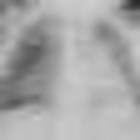

Prediction: Pneumonia
Ground Truth: Pneumonia


In [9]:
import random
from IPython.display import display

index = random.randint(0, len(test_dataset))

x, y = test_dataset[index]
display(x.resize((140, 140)))
x = np.array(x)
L = x.shape[0] * x.shape[1]
x = x.reshape(1, 1, L)/255.
pred = model(x)

pred = pred.squeeze(0).squeeze(0)
pred[pred>=0.5] = 1
pred[pred<0.5] = 0
print("Prediction: Pneumonia" if pred[0] else "Prediction: Healthy")
print("Ground Truth: Pneumonia" if y[0] else "Ground Truth: Healthy")